In [1]:
import autograd.numpy as np
from autograd.scipy.special import logsumexp,erf
from autograd.scipy.stats import norm
from autograd import grad

#from autograd_gamma import gamma, gammainc, gammaincc, gammaincln, gammainccln

import matplotlib.pyplot as plt
from copy import deepcopy
from itertools import product
from itertools import combinations
import pickle

from io import StringIO
from Bio import Phylo

from tree import Tree
from optimizer import Optimizer

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

/Users/evsi8432/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pop_size = 5.0 # exponential parameter for constant pop size prior
data_file = '../dat/DS1/DS1.pickle'
out_file = '../dat/DS1/DS1_optim.pickle'

In [3]:
with open(data_file, 'rb') as f:
    DS1 = pickle.load(f)

In [4]:
genomes = []
species = []
for key in DS1:
    genomes.append(DS1[key])
    species.append(key)
    
n_species = len(species)

In [5]:
# From https://github.com/zcrabbit/vbpi-torch/blob/ff86cf0c47a5753f5cc5b4dfe0b6ed783ab22669/unrooted/phyloModel.py#L7-L11
nuc2vec = {'A':[1.,0.,0.,0.], 'G':[0.,1.,0.,0.], 'C':[0.,0.,1.,0.], 'T':[0.,0.,0.,1.],
           '-':[1.,1.,1.,1.], '?':[1.,1.,1.,1.], 'N':[1.,1.,1.,1.], 'R':[1.,1.,0.,0.],
           'Y':[0.,0.,1.,1.], 'S':[0.,1.,1.,0.], 'W':[1.,0.,0.,1.], 'K':[0.,1.,0.,1.],
           'M':[1.,0.,1.,0.], 'B':[0.,1.,1.,1.], 'D':[1.,1.,0.,1.], 'H':[1.,0.,1.,1.],
           'V':[1.,1.,1.,0.], '.':[1.,1.,1.,1.], 'U':[0.,0.,0.,1.]}

tree_log_probs = np.array([[nuc2vec[g] for g in genome] for genome in genomes],
                                dtype = float)
tree_log_probs = np.log(tree_log_probs)

# Set initial $\theta$ using the consesus tree from BEAST

In [6]:
theta = np.zeros((2,n_species,n_species))

theta[0] = np.random.normal(size = (n_species,n_species)) + np.log(pop_size)
theta[0] = theta[0]*np.tril(np.ones((n_species,n_species)),k=-1)
theta[1] = 0.01*np.random.normal(size = (n_species,n_species))
theta[1] = theta[1]*np.tril(np.ones((n_species,n_species)),k=-1)

print(theta.shape)

(2, 27, 27)


In [7]:
times = 0.05 * np.ones((27,27))

# A Homo-sapiens, mus, rattus, Oryct
times[10,15] = 0.0061
times[10,17] = 0.0093
times[15,19] = 0.0042

# B Trach 23, Alligator 0, Scel 21, Hetero 9, Gallus 6, Turdus 24
times[0,23] = 0.0049
times[9,21] = 0.0072
times[0,9] = 0.0111
times[6,24] = 0.0076
times[6,23] = 0.0203

# C Disco 4, Amph 2, Hypo 12, Grand 8, Ich 13, Pleth 18, Sca 20
times[4,12] = 0.0141
times[2,12] = 0.0082
times[8,12] = 0.0028
times[12,13] = 0.01
times[18,13] = 0.0114
times[18,20] = 0.0052

# D Typh 25, siren 22, Amb 1
times[1,22] = 0.0053
times[1,25] = 0.0098

# E Neso 16, Eleu 5, Gatro 7, Hyla 11, Bufo 3
times[5,16] = 0.0138
times[5,7] = 0.0175
times[3,11] = 0.0157
times[3,16] = 0.0207

# A B
times[10,23] = 0.0312

# C D
times[4,22] = 0.0165

# CDE
times[5,22] = 0.0229

# CDE Xeno 26 Lat 14
times[5,26] = 0.0278
times[5,14] = 0.0348

# ABCDE
times[5,10] = 0.0406

In [8]:
log_times = np.log(times)

tree = Tree(theta,log_times,tree_log_probs,
            pop_size=pop_size)

theta = np.zeros((2,n_species,n_species))

for node in tree.nodes:
    combs = combinations(node.leaves,2)
    for inds in combs:
        inds = sorted(inds)
        theta[0,inds[1],inds[0]] = min(theta[0,inds[1],inds[0]],np.log(node.coal_time))
        theta[1,inds[1],inds[0]] = -2
        
print(theta.shape)

(2, 27, 27)


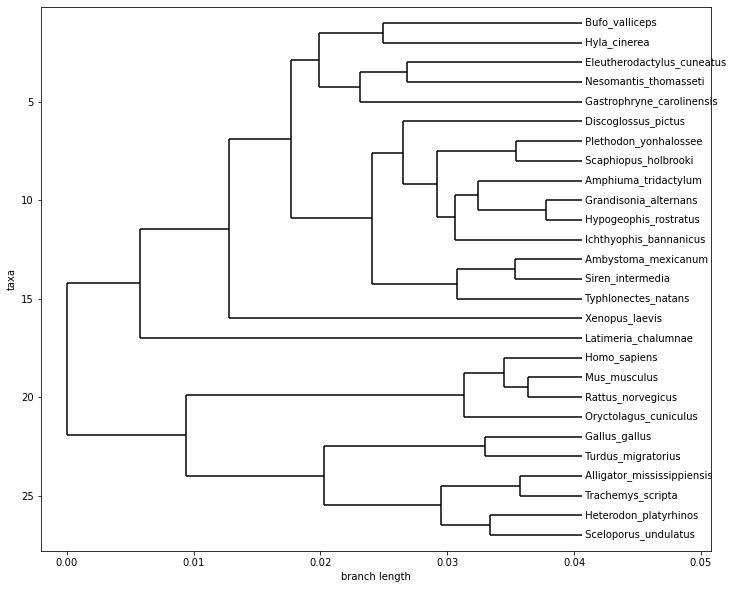

In [9]:
def write_newick(node):
    
    if node.children == []:
        return species[next(iter(node.leaves))] + ":" + str(node.parent.coal_time)
    elif node.parent is None:
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + ")"
    else:
        bl = node.parent.coal_time - node.coal_time
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + "):" + str(bl)


treedata = write_newick(tree.nodes[-1])
handle = StringIO(treedata)
tree_to_draw = Phylo.read(handle, "newick")

# Set up the plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)

# Draw the phylogenetic tree
Phylo.draw(tree_to_draw, axes=ax)

# perform variational inference

In [ ]:
optim_reparam = Optimizer(tree_log_probs,deepcopy(theta))

optim_reparam.optimize_q_reparam(100,100,alphas=[0.1,0.01],
                                 pop_size=pop_size)
#optim.optimize_q_reinforce(5,1000,alphas=[0.01,0.001],
#                           pop_size=np.ones_like(theta[0]))

0.0
runtime:  0:00:48.857524
grad_norm:  4958.556902700684

0.1
runtime:  0:09:02.381829
grad_norm:  1900.410915156484

0.2
runtime:  0:17:09.875036
grad_norm:  929.8468301121557

0.3
runtime:  0:24:50.763639
grad_norm:  1605.2486748659212

0.4
runtime:  0:32:35.516315
grad_norm:  758.1276485665077



In [ ]:
plt.plot(optim_reparam.ELBO_ests)
plt.show()
plt.plot(np.log(optim_reparam.grad_norms))
plt.show()

m = deepcopy(optim_reparam.theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(optim_reparam.theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()
plt.show()

In [ ]:
optim_reinforce = Optimizer(tree_log_probs,deepcopy(optim_reparam.theta))

optim_reinforce.optimize_q_reinforce(100,100,alphas=[0.01,0.01],
                                     pop_size=pop_size)
#optim.optimize_q_reinforce(5,1000,alphas=[0.01,0.001],
#                           pop_size=np.ones_like(theta[0]))

In [ ]:
plt.plot(optim_reinforce.ELBO_ests)
plt.show()
plt.plot(np.log(optim_reinforce.grad_norms))
plt.show()

m = deepcopy(optim_reinforce.theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(optim_reinforce.theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()

In [ ]:
m = deepcopy(optim_reinforce.theta[0] - optim_reparam.theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()
plt.show()

log_sig = deepcopy(optim_reinforce.theta[1] - optim_reparam.theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()

In [37]:
with open(out_file, 'wb') as file: 
    pickle.dump(optim_reinforce, file) 

In [38]:
optim = optim_reparam
theta = optim.theta

# Print out a random tree

In [39]:
Z = np.random.normal(np.ones_like(theta[0]))
log_times = np.exp(theta[1])*Z+theta[0]
log_times = log_times + np.triu(np.ones_like(theta[0])*np.inf)

tree = Tree(theta,log_times,tree_log_probs,
            pop_size=pop_size)

# draw the random tree using a newick file

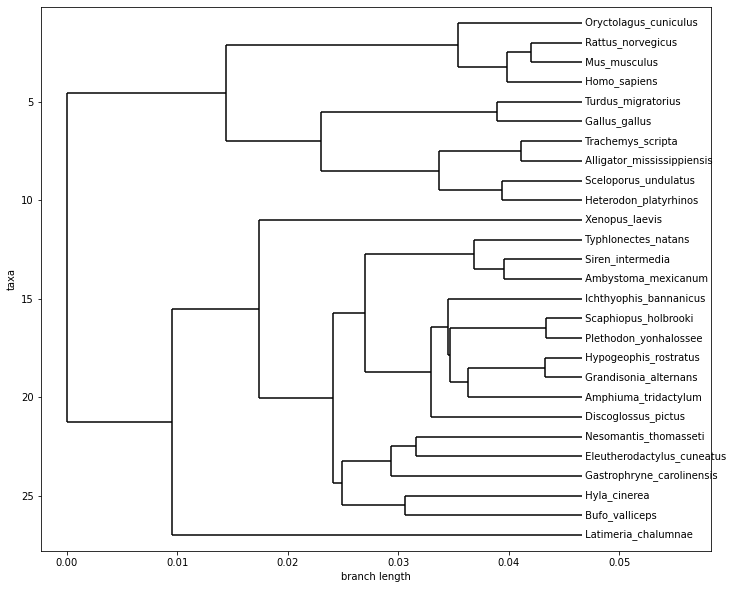

-6984.189774278744
-42.561236213293014
-7026.7510104920375


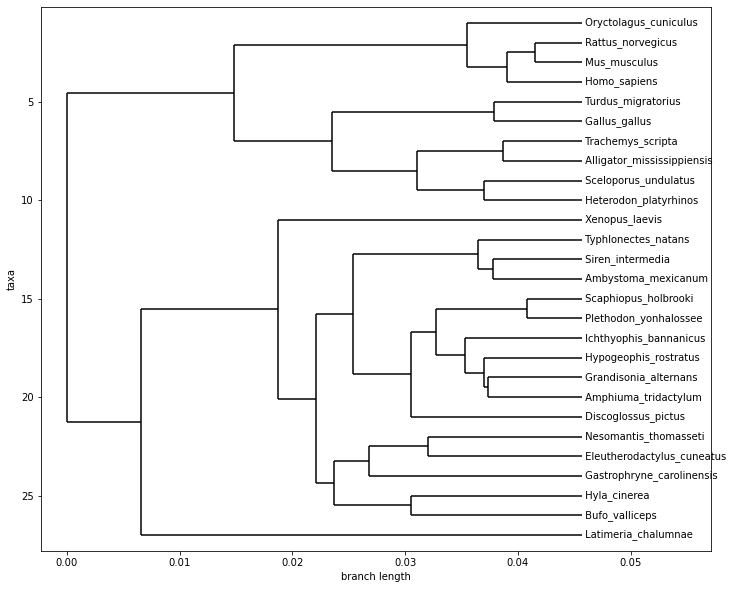

-6993.786606621525
-42.597483778986614
-7036.384090400511


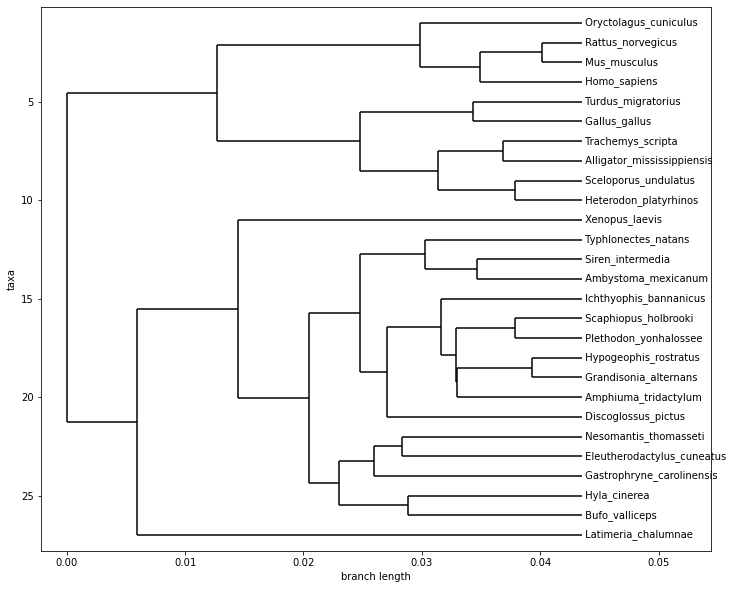

-6990.144526106147
-42.596285214634854
-7032.740811320782


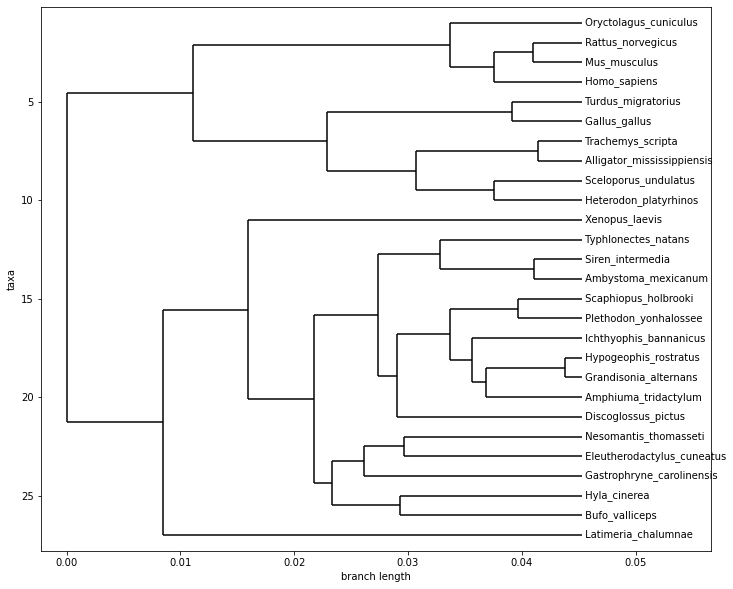

-6977.399490032874
-42.5479055028498
-7019.947395535724


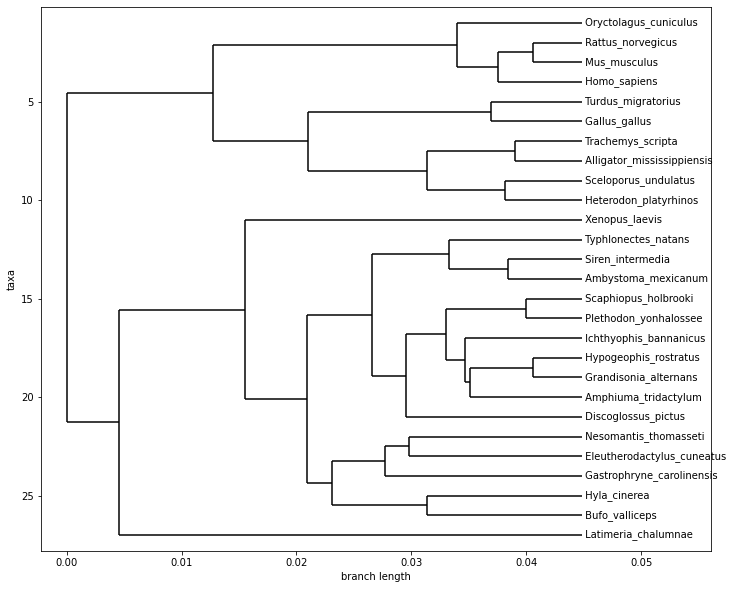

-6977.801365390621
-42.56792749513534
-7020.369292885756


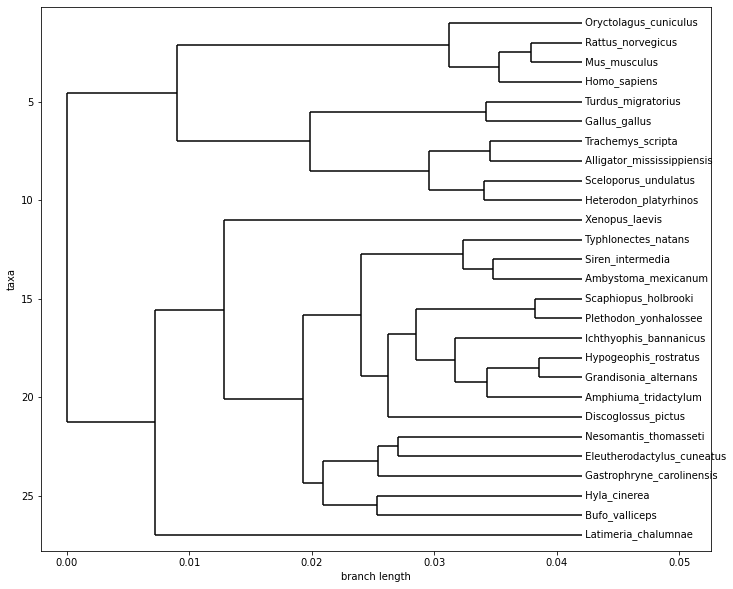

-6974.775693563208
-42.56236831614927
-7017.338061879357


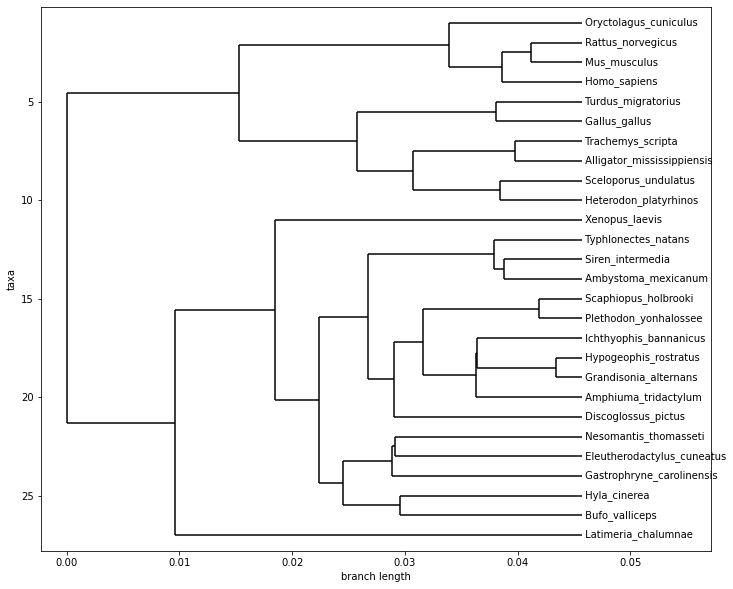

-6997.674469782137
-42.556942907669615
-7040.231412689806


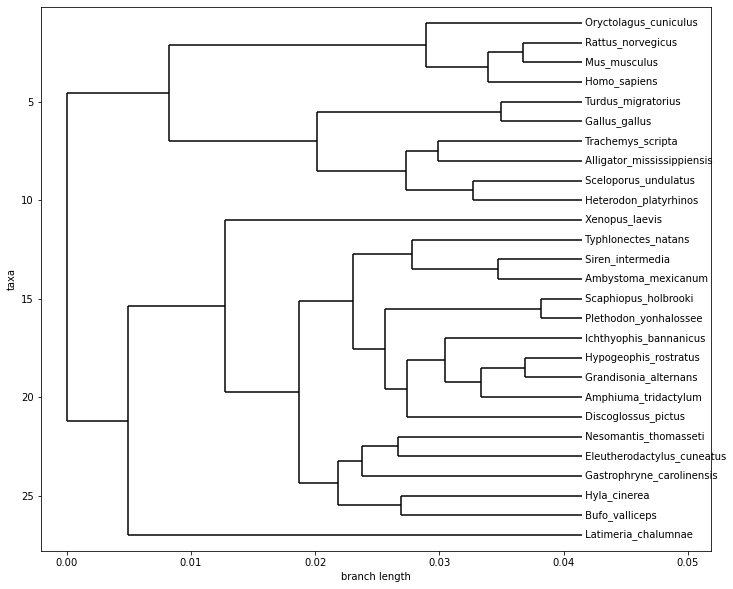

-6995.205083982003
-42.603845013874874
-7037.808928995878


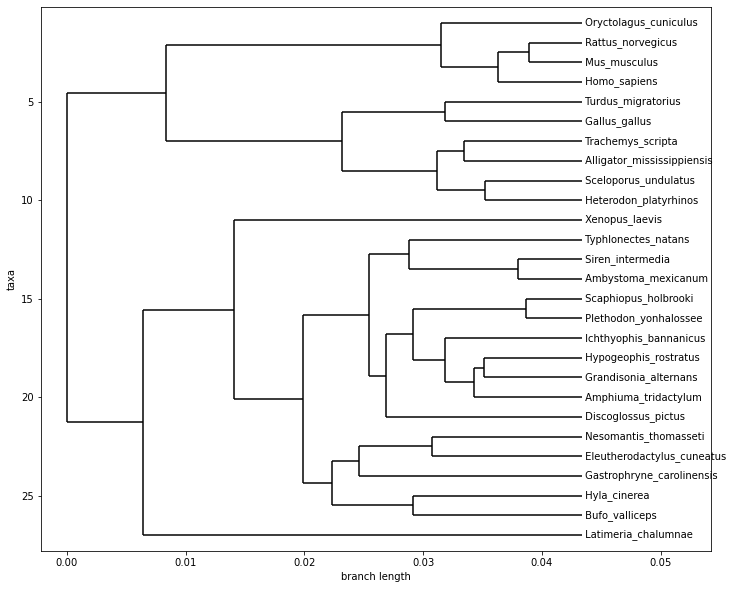

-6990.417063550633
-42.62853349095387
-7033.045597041587


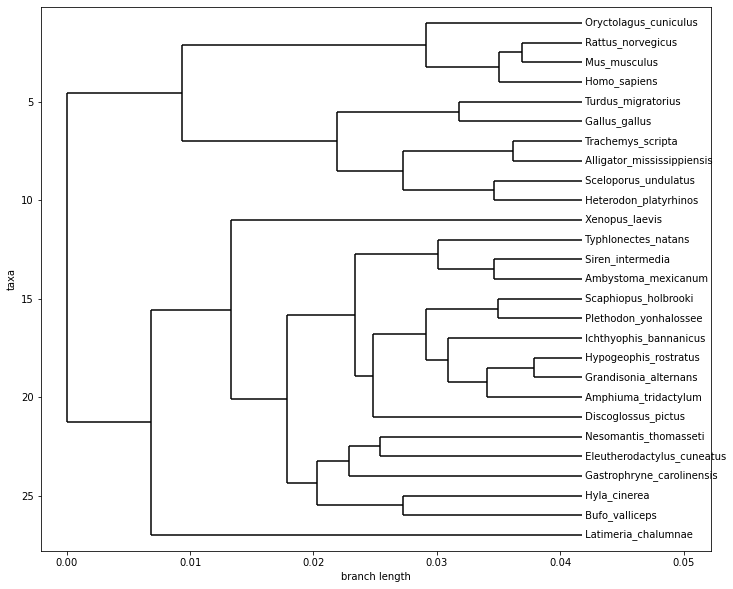

-6978.663426536827
-42.59555963868315
-7021.25898617551


In [40]:
for _ in range(10):
    Z = np.random.normal(np.ones_like(theta[0]))
    log_times = np.exp(theta[1])*Z+theta[0]
    log_times = log_times + np.triu(np.ones_like(theta[0])*np.inf)

    tree = Tree(theta,log_times,tree_log_probs,
                pop_size=pop_size)

    def write_newick(node):

        if node.children == []:
            return species[next(iter(node.leaves))] + ":" + str(node.parent.coal_time)
        elif node.parent is None:
            return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + ")"
        else:
            bl = node.parent.coal_time - node.coal_time
            return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + "):" + str(bl)


    treedata = write_newick(tree.nodes[-1])
    handle = StringIO(treedata)
    tree_to_draw = Phylo.read(handle, "newick")

    # Set up the plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1, 1, 1)

    # Draw the phylogenetic tree
    Phylo.draw(tree_to_draw, axes=ax)

    print(tree.log_like)
    print(tree.log_prior)
    print(tree.log_p)

# Estimate the marginal likelihood

In [41]:
tree.nodes[-1].coal_time

0.04175248347898654

In [42]:
n_exp = 100
n_samples = 10

# get priors and log-liklihoods
priors = []
LL = []

# get root heights
rootHeights = []

# get tree topologies
tree_hash = {}
top_counts = {}

# get marginal log-likelihoods and ELBOs
MLL_all = np.zeros(n_exp)
ELBO_all = np.zeros(n_exp)

for i in range(n_exp):
    
    print(i)
    
    MLL = np.zeros(n_samples)
    ELBO = np.zeros(n_samples)
    Zs = np.random.normal(size=(n_samples,n_species,n_species))

    for j,Z in enumerate(Zs):
        log_times = np.exp(theta[1])*Z+theta[0]
        log_times = log_times + np.triu(np.full(n_species, np.inf))
        tree = Tree(optim.theta,log_times,deepcopy(tree_log_probs),
                    pop_size=pop_size)
        
        MLL[j] = tree.log_p - tree.log_q
        ELBO[j] = tree.log_p - tree.log_q
        
        LL.append(tree.log_like)
        priors.append(tree.log_prior)
        rootHeights.append(tree.nodes[-1].coal_time)
        
        tree_top = frozenset([frozenset(x.leaves) for x in tree.nodes])
        if tree_top in tree_hash:
            top_counts[tree_hash[tree_top]] += 1
        else:
            tree_hash[tree_top] = len(tree_hash)
            top_counts[tree_hash[tree_top]] = 1
        
    MLL_all[i] = logsumexp(MLL) - np.log(n_samples)
    ELBO_all[i] = np.mean(ELBO)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


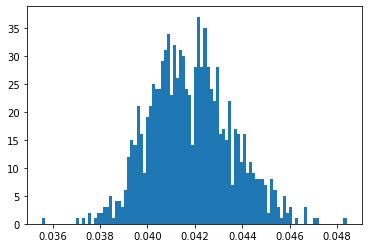

0.04183268275752679


In [43]:
plt.hist(rootHeights,bins = 100)
plt.show()
print(np.mean(rootHeights))

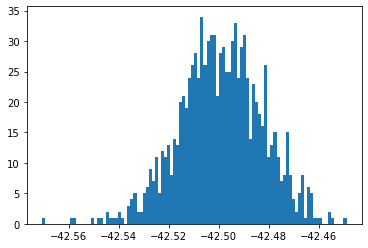

-42.499136481159184


In [44]:
plt.hist(priors,bins = 100)
plt.show()
print(np.mean(priors))

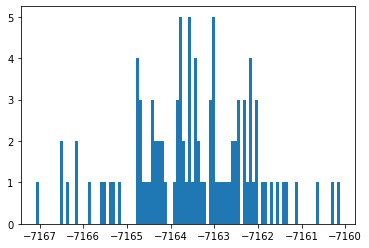

-7163.485703013495


In [45]:
plt.hist(ELBO_all,bins = 100)
plt.show()
print(np.mean(ELBO_all))

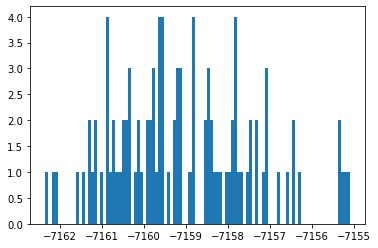

-7159.062075708329


In [46]:
plt.hist(MLL_all,bins = 100)
plt.show()
print(np.mean(MLL_all))

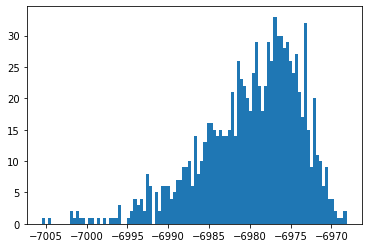

-6979.8554518402425


In [47]:
plt.hist(LL,bins = 100)
plt.show()
print(np.mean(LL))

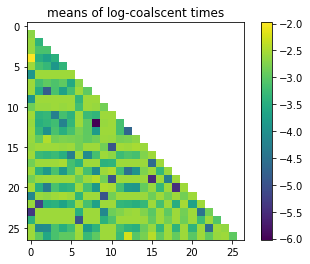

In [48]:
m = deepcopy(theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()

log_sig = deepcopy(theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()

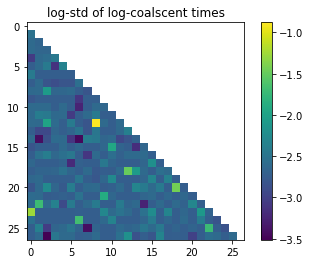

In [49]:
log_sig = deepcopy(theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()